In [1]:
from pathlib import Path
import pyrootutils
import os 
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
import pandas as pd
root = pyrootutils.setup_root(
    search_from=os.path.abspath(''),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True)
_HYDRA_PARAMS = {
    "version_base": "1.3",
    "config_dir": str(root / "configs"),
}
with initialize_config_dir(**_HYDRA_PARAMS):
    cfg = compose(config_name='train')
    OmegaConf.resolve(cfg)
    print(cfg)

 #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

{'path': {'raw': '/home/yacine/Documents/personal_project/code/dcase/dcase2024_task2/dev_data'}}


In [2]:
from data_manager import get_machine_manager

mm = get_machine_manager(cfg.path.raw)
mm.BEARING.data_reader

Machine: bearing, attribute parameterfile: 
    d1p d1p.1 d1p.2
0  pro   vel   loc 
        
                               0
d1v                      [A, B]
d1v.1            [4, 12, 8, 16]
d1v.2  [A, B, C, D, E, F, G, H]

In [170]:
from enum import Enum
from pathlib import Path

class MachineType(Enum):
    def __init__(self, name, path):
        self._name = name
        self._path = path
        self.data_reader = DataReaderSingleMachine(name,path)

    @property
    def name(self):
        return self._name

    @property
    def path(self):
        return self._path
    
    @property 
    def reader(self):
        return self.data_reader
    



machine_names_with_paths = get_machines_names(cfg.path.raw)



print(MachineType.BEARING.reader.process_files(stage='train'))


[(PosixPath('/home/yacine/Documents/personal_project/code/dcase/dcase2024_task2/dev_data/bearing/train/section_00_source_train_normal_0001_pro_A_vel_4_loc_A.wav'), ['A', 4, 'A']), (PosixPath('/home/yacine/Documents/personal_project/code/dcase/dcase2024_task2/dev_data/bearing/train/section_00_source_train_normal_0002_pro_A_vel_4_loc_A.wav'), ['A', 4, 'A']), (PosixPath('/home/yacine/Documents/personal_project/code/dcase/dcase2024_task2/dev_data/bearing/train/section_00_source_train_normal_0003_pro_A_vel_4_loc_A.wav'), ['A', 4, 'A']), (PosixPath('/home/yacine/Documents/personal_project/code/dcase/dcase2024_task2/dev_data/bearing/train/section_00_source_train_normal_0004_pro_A_vel_4_loc_A.wav'), ['A', 4, 'A']), (PosixPath('/home/yacine/Documents/personal_project/code/dcase/dcase2024_task2/dev_data/bearing/train/section_00_source_train_normal_0005_pro_A_vel_4_loc_A.wav'), ['A', 4, 'A']), (PosixPath('/home/yacine/Documents/personal_project/code/dcase/dcase2024_task2/dev_data/bearing/train/se

In [162]:
class DataReaderSingleMachine():
    def __init__(self, machine_name: str, directory_path: str | Path, csv_file_name: str= "attributes_00.csv"):
        self.machine_name = machine_name
        self.directory_path = Path(directory_path)
        self.data_path = self.directory_path.parent
        self.csv_file_name = csv_file_name
        self.attribute = self.read_attribute()

    def read_attribute(self) -> pd.DataFrame:
        csv_file_path = self.directory_path / self.csv_file_name
        if not csv_file_path.exists():
            self.attribute = None
            return None
        return pd.read_csv(csv_file_path)
        

    def get_files_path(self,stage: str):
        if stage not in ["train", "test"]:
            raise ValueError("Stage must be either train or test")
        return self.directory_path / stage

    def get_files_path_attribute(self, stage: str):
        if self.attribute is None:
            print("No attribute file found for this machine")
            return self.get_files_path(stage)
        paths = self.get_files_path(stage)
        file_attributes = self.attribute[self.attribute['file_name'].str.contains(f"/{stage}/")]
        # file_attribute are relatibe file paths, we need to join them with the full path that is in the list of paths 
        file_attributes.loc[:,'file_name']= file_attributes['file_name'].apply(lambda x: self.data_path / x)
        return file_attributes
    
    def get_possible_parameter(self, stage: str):
        if self.attribute is None:
            print("No attribute file found for this machine")
            return None
        values_col = [col for col in self.attribute.columns if 'v' in col]
        param_col = [col for col in self.attribute.columns if 'p' in col]
        # get the unique values for each parameter column
        unique_param = self.attribute[param_col].apply(lambda x: x.unique())
        unique_values = self.attribute[values_col].apply(lambda x: x.unique())
        return unique_param, unique_values

    def process_files(self, stage: str):
        if self.attribute is None:
            print("No attribute file found for this machine")
            return None
        df  = self.get_files_path_attribute(stage)
        data_path_and_attributes = []
        for index, row in df.iterrows():
            path = row['file_name']
            if not Path(path).exists():
                break
            attribute = row.drop('file_name').to_dict()
            attribute = [v for k, v in attribute.items() if 'v' in k]
            data_path_and_attributes.append((path, attribute))
        return data_path_and_attributes

    def __repr__(self):
        return f"Machine: {self.machine_name}"

In [7]:
#load .wav files
import soundfile as sf
import numpy as np

def load_wav(file_path: str | Path) -> np.ndarray:
    data, samplerate = sf.read(file_path)
    return data, samplerate

In [8]:
d,s = load_wav(paths[15])

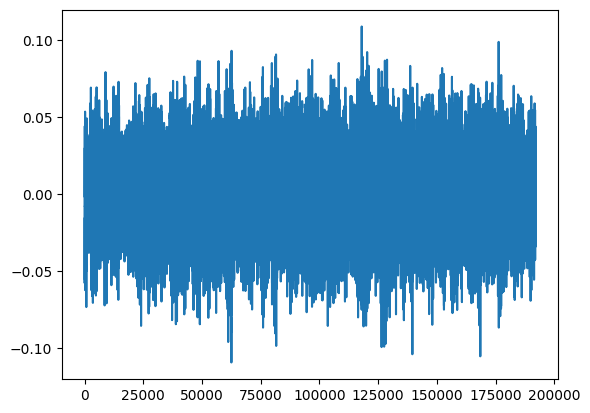

In [9]:
import matplotlib.pyplot as plt
plt.plot(d)


In [10]:
# hear the sound
import IPython.display as ipd
ipd.Audio(15*d, rate=s)

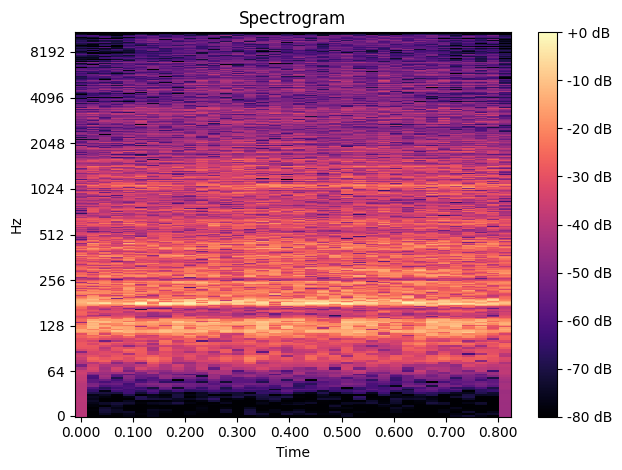

In [11]:
# extract spectrogram and fft 
import librosa
import librosa.display

def extract_spectrogram(data: np.ndarray, samplerate: int, n_fft: int = 8196, hop_length: int = 8196*2/3) -> np.ndarray:
    
    S = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=int(hop_length)))
    return S

S = extract_spectrogram(d, s)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()


In [15]:
import scipy.signal as sig
# autocorrelation 
from spectrum import pyule, arma, aryule,pmusic,pev, pmodcovar
# downsampling d to 100 Hz 
#d = sig.resample(d, len(d)//(s//100))
p = pmodcovar(d, 100, sampling=100)
#ar, rho, k = aryule(d,order=500, norm='biased')
ff = np.fft.fftfreq(len(d), 1/100)
ffft = np.fft.fft(d)

f,pxx = sig.welch(d,nperseg=4096,noverlap=3000, fs=100)
fig,ax = plt.subplots()
ax.plot(f, pxx)
ax.plot(ff, np.abs(ffft)/10000)
ax.plot(p.frequencies(), p.psd/1000)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_yscale('log')
ax.set_xlim(0, 1500)


ValueError: noverlap must be less than nperseg.

(0.0, 1500.0)

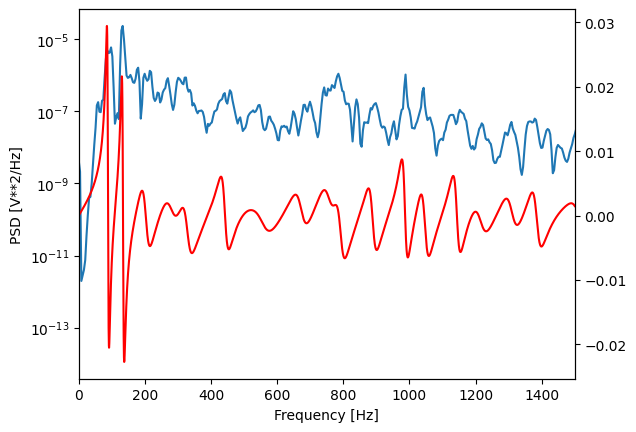

In [16]:
fig,ax = plt.subplots()
ax.plot(f, pxx)
ax1 = ax.twinx()
ax1.plot(p.frequencies()[1:], np.diff(np.log(p.psd)), color='red')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
ax.set_yscale('log')
ax.set_xlim(0, 1500)

Text(0, 0.5, 'Amplitude')

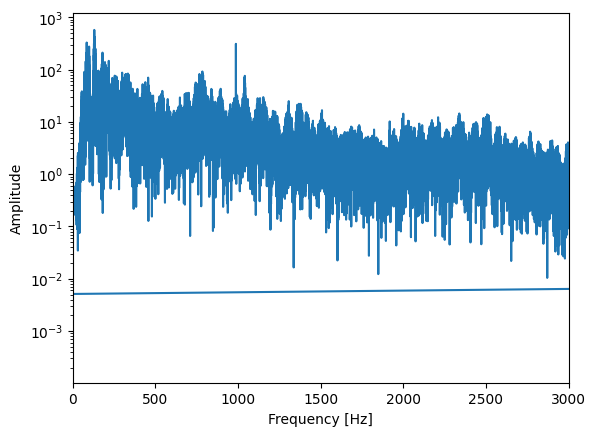

In [17]:
S = np.fft.fft(d)
f = np.fft.fftfreq(len(d), 1/s)
plt.plot(f, np.abs(S))
plt.xlim(0, 3000)
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')


In [18]:
from functools import partial
class MPE:
    AVAILABLE_BASES = ['power', 'exp']
    def __init__(self,Md:int,Mn:int,base:str,f_max:float,prct:float=0.8):
        self.Mn = Mn
        self.Md = Md
        self.base = base
        self.f_max = f_max
        self.prct = prct
        self.check_params()

    def check_params(self):
        if 0 <= self.Md < self.Mn:
            raise ValueError(f"Md ({self.Md}) must be greater than Mn ({self.Mn})")

    
    def basis_function(self,f:np.array, conv:str = 'normal'):
        func_dict = {
            ('power', 'normal'):  lambda f: 1j *2*np.pi* f *self.prct / self.f_max,
            ('power', 'inverse'): lambda x: x * self.f_max/(self.prct * 2 * np.pi*1j),

            ('exp', 'normal'):    lambda x: np.exp(-1j *2*np.pi* self.prct*x/self.f_max ),
            ('exp', 'inverse'):   lambda x: -np.log(x) * self.f_max/(self.prct*2*np.pi*1j),
        }

        func = func_dict.get((self.base, conv))
        if func is None:
            raise ValueError(f"Unsupported combination of base and conv: {self.base}, {conv}")
        return func(f)
    
    def inverse_basis_function(self,x):
        return self.basis_function(x,conv='inverse') 
    
    def direct_basis_function(self,x):
        return self.basis_function(x,conv='normal')
    
    def _observation_matrix(self,freq,M):
        one_col = self.basis_function(freq,conv='normal')
        if self.base not in self.AVAILABLE_BASES:
            raise ValueError(f"Unsupported base: {self.base}")
        res = np.power(one_col.reshape((-1,1)),np.arange(M+1))
        return res

    
    def _build_LHS_matrix(self,freq,psd):
        denom = np.repeat(psd.reshape((-1, 1)), self.Md+1, axis=1)
        Sd = self._observation_matrix(freq,M=self.Md)
        Sn = self._observation_matrix(freq,M=self.Mn)
        Sdenom = np.multiply(Sd, denom)
        return np.hstack([Sdenom, -Sn])
    
    def _add_constraint(self,LHS):
        RHS = LHS[:, self.Md]
        LHS_new = np.delete(LHS, self.Md, axis=1)
        return LHS_new, RHS
    def _solve_eq(self,LHS, RHS):
        theta, _, _, _ = np.linalg.lstsq(LHS, -RHS, rcond=-1)
        return theta
    
    def _repair_constraint(self,theta):
        theta = np.insert(theta, self.Md, 1)
        return theta
    
    def estimate(self,freq,psd):
        LHS = self._build_LHS_matrix(freq,psd)
        LHS, RHS = self._add_constraint(LHS)
        theta = self._solve_eq(LHS, RHS)
        theta = self._repair_constraint(theta)
        return theta
    
    def get_num_den(self,freq,psd):
        theta = self.estimate(freq,psd)
        den = np.poly1d(np.flip(theta[:self.Md+1]))
        num = np.poly1d(np.flip(theta[self.Md+1:]))
        
        return  num, den
    
    def get_TransferFunction(self,num,den):
        def tf(f):
            omegaj = self.direct_basis_function(f) 
            num_val = num(omegaj)
            den_val = den(omegaj)
            return num_val / den_val
        return np.vectorize(tf)
    
from typing import Tuple
class alter_psd():
    def __init__(self, mpe : MPE,f_max:int,resolution:int=200):
        self.resolution = resolution
        self.mpe = mpe
        self.f_max = f_max

    def tf_area(self,num,den):
        tf= self.mpe.get_TransferFunction(num,den)
        freq = np.linspace(0, self.f_max, self.resolution)
        df = freq[1]-freq[0]
        area = np.trapz(np.abs(tf(freq)), freq, dx=df)
        return area
    
    def equalize_tf_area(self,num_den_o:Tuple,num_den_n:Tuple):
        num_o,den_o = num_den_o
        num_n,den_n = num_den_n
        area_o = self.tf_area(num_o,den_o)
        area_n = self.tf_area(num_n,den_n)
        num_n = num_n * area_o / area_n
        return num_n,den_n

    
    def shift_frequency(self, num,den,freq_loc:int,freq_shift:int):
        poles = den.r
        poles = self.mpe.inverse_basis_function(poles)
        resfreq = np.abs(poles)
        
        # Find the two poles closest to freq_loc
        idx_poles_oi = np.argsort(np.abs(resfreq - freq_loc))[:2] 
        
        for i in idx_poles_oi:
            poles[i] *=  (1 + freq_shift / poles[i] )

        poles = self.mpe.direct_basis_function(poles)
        den_n = np.poly1d(poles, r=True)
        num_n, den_n= self.equalize_tf_area((num,den),(num,den_n))
        tf = self.mpe.get_TransferFunction(num_n,den_n)
        return tf, num_n,den_n

In [29]:
num

poly1d([ 2.81771807e-09-1.28270104e-09j, -4.94188522e-10+3.92768188e-09j,
       -4.86973541e-09-1.05160300e-09j, -2.66780292e-10-2.34618300e-09j,
        1.56327118e-09+2.76659695e-10j, -6.99810803e-10-3.87776223e-10j,
       -1.18847863e-09-1.69551595e-09j,  2.08474758e-10-9.71621429e-11j,
        1.01962877e-09-7.07527321e-10j, -4.34904153e-10+1.95412207e-10j,
       -1.46239482e-09-2.55221544e-10j,  6.38692328e-10-9.85852334e-10j,
        8.62456814e-10-4.53418622e-11j, -4.54417585e-10+8.32724679e-10j,
       -8.63362483e-10-1.63398588e-09j,  3.71122102e-10-3.37595602e-10j,
       -2.26657481e-10-5.61883354e-10j,  5.58338965e-10-1.22025490e-10j,
        4.56762869e-10+6.71675181e-11j,  3.81047940e-10+2.22762780e-13j,
        1.29262633e-09+5.94083799e-10j, -4.78366903e-10+1.75939026e-10j,
       -9.19170384e-10-1.70560212e-10j, -4.35043501e-10+1.66831091e-10j,
        2.93568652e-10+3.31392344e-11j, -5.23306419e-10+3.35978002e-10j,
       -6.86596439e-10-4.40113628e-10j,  1.3798167

(0.0, 1500.0)

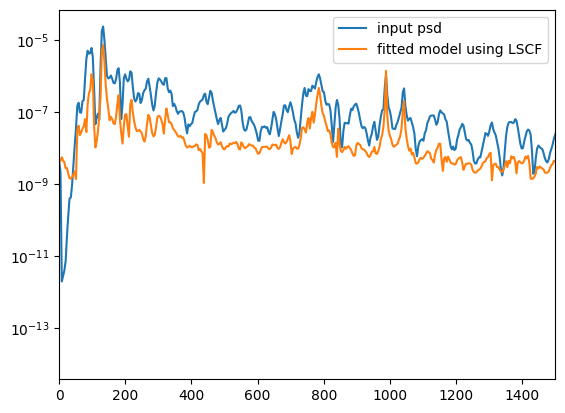

In [28]:
f,pxx = sig.welch(d,nperseg=4096,noverlap=3000, fs=s)

mpe = MPE(Md=250,Mn=250,base='exp',f_max=2000,prct=0.8)
num,den = mpe.get_num_den(f,pxx)
tf = mpe.get_TransferFunction(num,den)
plt.plot(f, pxx, label='input psd')
plt.plot(f, np.abs(tf(f)), label='fitted model using LSCF')
plt.yscale('log')
plt.legend()
plt.xlim([0,1500])

